In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [3]:
cwd = os.getcwd()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/My\ Drive/Development_Dataset.zip

Archive:  /content/drive/My Drive/Development_Dataset.zip
  inflating: Development_Dataset/LICENSE.txt  
   creating: Development_Dataset/Test_Dev/
   creating: Development_Dataset/Test_Dev/Bipbip/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/
   creating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00211.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00581.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00721.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_00951.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_01341.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02421.jpg  
  inflating: Development_Dataset/Test_Dev/Bipbip/Haricot/Images/Bipbip_haricot_im_02781.jpg  
  inflating: Developm

# Example: Image Segmentation
## Build segmentation

In [7]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [8]:
from PIL import Image

def read_rgb_mask(img_path, res_h, res_w):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_img = mask_img.resize([res_w, res_h])
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [9]:
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from skimage import io, transform
from sklearn.model_selection import train_test_split


# Need to adjust height and width so that input and output after decode have same shape
IMG_CHANNELS = 3
IMG_HEIGHT = 736
IMG_WIDTH = 1472
my_path = '/content/Development_Dataset/Training/Bipbip/Mais'

image_ids = [f for f in listdir(my_path + '/Images/') if isfile(join(my_path + '/Images/', f))]
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 3))
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH))
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
  path = my_path
  img = io.imread(path + '/Images/' + id_)[:,:,:IMG_CHANNELS]
  img = transform.resize(img, (IMG_HEIGHT, IMG_WIDTH), mode ='constant', preserve_range=True)
  X[n] = img/255.
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.bool)
  mask_id = id_.replace('jpg', 'png')
  mask = read_rgb_mask(path + '/Masks/' + mask_id, IMG_HEIGHT, IMG_WIDTH)
  Y[n] = mask

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.15, random_state=SEED)

100%|██████████| 90/90 [00:48<00:00,  1.84it/s]


In [10]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  # train_valid should be [x_train, y_train] or [x_valid, y_valid]
  def __init__(self, train_valid, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):

    self.train_valid = train_valid
    self.which_subset = which_subset
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.train_valid[0])

  def __getitem__(self, index):    
    img_arr = self.train_valid[0][index]
    mask_arr = self.train_valid[1][index]

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    # mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [11]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = IMG_HEIGHT
img_w = IMG_WIDTH

dataset = CustomDataset([x_train, y_train], 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=None, out_shape=[IMG_HEIGHT, IMG_WIDTH])
dataset_valid = CustomDataset([x_valid, y_valid], 'validation', 
                              preprocessing_function=None, out_shape=[IMG_HEIGHT, IMG_WIDTH])

In [12]:
img_h = IMG_HEIGHT
img_w = IMG_WIDTH
bs = 2

# np.newaxis to transform [IMG_HEIGHT, IMG_WIDTH] into [IMG_HEIGHT, IMG_WIDTH, 1]
#dataset = zip(x_train, y_train[..., np.newaxis])
#dataset_valid = zip(x_valid,  y_valid[..., np.newaxis])
print(x_train.shape)

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

(76, 736, 1472, 3)


In [13]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


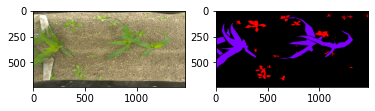

In [14]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img * 255.  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)
print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [15]:
xce = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
for layer in xce.layers:
  layer.trainable = False

83689472/83683744 [==============================] - 0s 0us/step


## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [16]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(xce)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [17]:
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=3)

# Visualize created model as a table
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 23, 46, 2048)      20861480  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 46, 92, 2048)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 92, 256)       4718848   
_________________________________________________________________
re_lu (ReLU)                 (None, 46, 92, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 92, 184, 256)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 92, 184, 128)      295040    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 92, 184, 128)      0

## Prepare the model for training

In [18]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [19]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, '/content/drive/MyDrive/NN_Homework_2', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)

In [ ]:
model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(list(dataset)) // bs,
          validation_data=valid_dataset,
          validation_steps=len(list(dataset_valid)) // bs, 
          callbacks=callbacks)

## Test model

## Compute prediction

In [29]:
model.load_weights('/content/drive/My Drive/Final_weights/CNN_xce/best.ckpt')

In [21]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(valid_dataset)

(1, 736, 1472, 3)

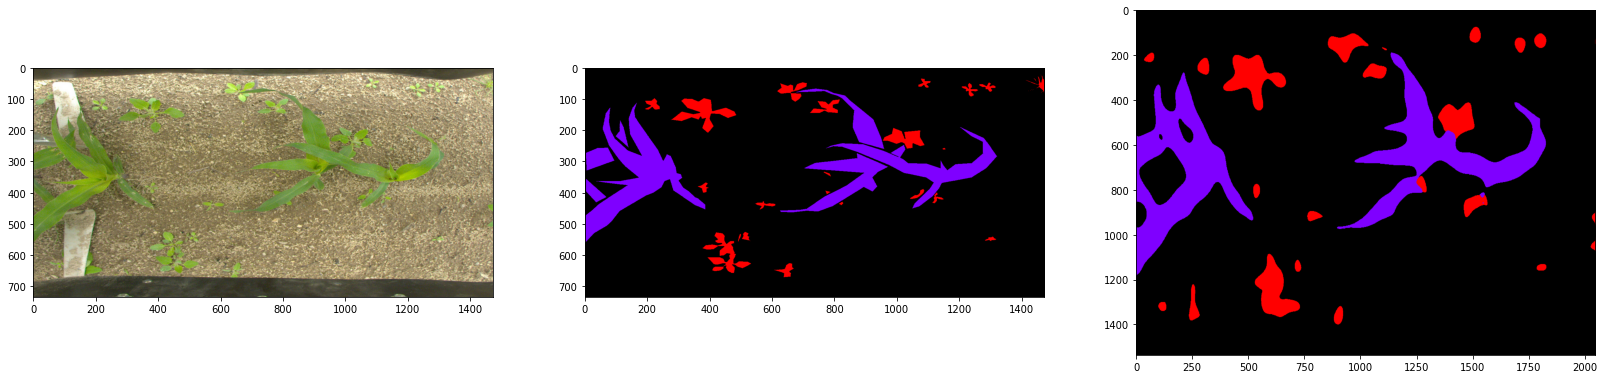

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(28, 28))
fig.show()

DEF_HEIGHT = 1536
DEF_WIDTH = 2048

image, target = next(iterator)

image = image[0]
image_disp = image * 255.
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

prediction_up = np.zeros([target.shape[0], target.shape[1]])
prediction_up[np.where(predicted_class == 0)] = 0
for i in range(1, 3):
  prediction_up[np.where(predicted_class == i)] = i
mask_up = Image.fromarray(prediction_up)
mask_up = mask_up.resize(size=(DEF_WIDTH, DEF_HEIGHT), resample=Image.NEAREST)
prediction_up = np.array(mask_up)

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([prediction_up.shape[0], prediction_up.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(prediction_up == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(prediction_up == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image_disp))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

In [23]:
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from skimage import io, transform
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Need to adjust height and with so that input and output after decode have same shape
#IMG_CHANNELS = 3
#IMG_HEIGHT = 736
#IMG_WIDTH = 1472
my_path = '/content/Development_Dataset/Test_Dev/Bipbip/Mais'

image_ids = [f for f in listdir(my_path + '/Images/') if isfile(join(my_path + '/Images/', f))]
x_test = defaultdict(dict)
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
  print(id_)
  path = my_path
  img = io.imread(path + '/Images/' + id_)[:,:,:IMG_CHANNELS]
  img = transform.resize(img, (IMG_HEIGHT, IMG_WIDTH), mode ='constant', preserve_range=True)
  x_test[id_] = img/255.

"""x_all = X

dataset_test = CustomDataset(x_all, 'test', 
                              preprocessing_function=None, out_shape=[IMG_HEIGHT, IMG_WIDTH])

test_dataset = tf.data.Dataset.from_generator(lambda: dataset_test,
                                               output_types=(tf.float32),
                                               output_shapes=([img_h, img_w, 3]))

iterator = iter(test_dataset)"""

  0%|          | 0/15 [00:00<?, ?it/s]

Bipbip_mais_im_09091.jpg


  7%|▋         | 1/15 [00:00<00:06,  2.13it/s]

Bipbip_mais_im_05521.jpg


 13%|█▎        | 2/15 [00:00<00:05,  2.26it/s]

Bipbip_mais_im_09571.jpg


 20%|██        | 3/15 [00:01<00:05,  2.38it/s]

Bipbip_mais_im_01931.jpg


 27%|██▋       | 4/15 [00:01<00:04,  2.46it/s]

Bipbip_mais_im_03621.jpg


 33%|███▎      | 5/15 [00:01<00:03,  2.55it/s]

Bipbip_mais_im_07611.jpg


 40%|████      | 6/15 [00:02<00:03,  2.57it/s]

Bipbip_mais_im_10441.jpg


 47%|████▋     | 7/15 [00:02<00:03,  2.51it/s]

Bipbip_mais_im_06381.jpg


 53%|█████▎    | 8/15 [00:03<00:02,  2.50it/s]

Bipbip_mais_im_06831.jpg


 60%|██████    | 9/15 [00:03<00:02,  2.43it/s]

Bipbip_mais_im_07681.jpg


 67%|██████▋   | 10/15 [00:03<00:02,  2.45it/s]

Bipbip_mais_im_10941.jpg


 73%|███████▎  | 11/15 [00:04<00:01,  2.46it/s]

Bipbip_mais_im_04121.jpg


 80%|████████  | 12/15 [00:04<00:01,  2.46it/s]

Bipbip_mais_im_11021.jpg


 87%|████████▋ | 13/15 [00:05<00:00,  2.48it/s]

Bipbip_mais_im_09781.jpg


 93%|█████████▎| 14/15 [00:05<00:00,  2.32it/s]

Bipbip_mais_im_02211.jpg


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


"x_all = X\n\ndataset_test = CustomDataset(x_all, 'test', \n                              preprocessing_function=None, out_shape=[IMG_HEIGHT, IMG_WIDTH])\n\ntest_dataset = tf.data.Dataset.from_generator(lambda: dataset_test,\n                                               output_types=(tf.float32),\n                                               output_shapes=([img_h, img_w, 3]))\n\niterator = iter(test_dataset)"

In [24]:
import os
import json
import numpy as np
from PIL import Image

res_dir = os.path.join(exp_dir, 'Results')
if not os.path.exists(res_dir):
    os.makedirs(res_dir)
res_fname = 'results_'
res_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.json'
test_path = '/content/Development_Dataset/Test_Dev'


def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



# The submission file will be a zip file containing the a
# submission.json file.

# It must have the following structure:

# - image name (without any extension, e.g., png, jpg, etc.)
#   - shape: shape of the original image as list [Height, Width]
#   - team: team of the original image. One in {'Bipbip', 'Pead', 'Roseau', 'Weedelec'}
#   - crop: crop of the original image. One in {'Haricot', 'Mais'}
#   - segmentation: prediction (as a dict)
#     - crop: RLE encoded crop segmentation (no weed)
#     - weed: RLE encoded weed segmentation (no crop)

# Please refer to the folder structure of the given dataset to fill
# the team and crop keys.

# EXAMPLE:

# Suppose that the numpy array generated with the
# 'read_mask_example.py' script is the output of your segmentation model.
# In addition, suppose that the team and crop of the segmented image
# are 'Bipbip' and 'Haricot', respectively.
# Then, in the following an example of submission file.

submission_dict = {}
shape_dict = defaultdict(dict)
shape_dict['Bipbip'] = [1536, 2048]
shape_dict['Pead'] = [2464, 3280]
shape_dict['Roseau'] = [819, 1228]
shape_dict['Weedelec'] = [3456, 5184]

for key in x_test:

  img_name = key.replace('.jpg', '').replace('.png', '')
  out_sigmoid = model.predict(x=tf.expand_dims(x_test[key], 0))

  # Get predicted class as the index corresponding to the maximum value in the vector probability
  # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
  # predicted_class = predicted_class[0, ..., 0]
  predicted_class = tf.argmax(out_sigmoid, -1)

  predicted_class = predicted_class[0, ...]

  if IMG_HEIGHT != shape_dict['Bipbip'][0] or IMG_WIDTH != shape_dict['Bipbip'][1]:
    # NB here shape adjusted!!!
    prediction_up = np.zeros([IMG_HEIGHT, IMG_WIDTH])
    prediction_up[np.where(predicted_class == 0)] = 0
    for i in range(1, 3):
      prediction_up[np.where(predicted_class == i)] = i
    mask_up = Image.fromarray(prediction_up)
    mask_up = mask_up.resize(size=(DEF_WIDTH, DEF_HEIGHT), resample=Image.NEAREST)
    prediction_up = np.array(mask_up)
  else:
    prediction_up = np.zeros([IMG_HEIGHT, IMG_WIDTH])
    prediction_up[np.where(predicted_class == 0)] = 0
    for i in range(1, 3):
      prediction_up[np.where(predicted_class == i)] = i

  dummy = prediction_up

  submission_dict[img_name] = {}
  submission_dict[img_name]['shape'] = prediction_up.shape
  submission_dict[img_name]['team'] = 'Bipbip'
  submission_dict[img_name]['crop'] = 'Mais'
  submission_dict[img_name]['segmentation'] = {}

  # RLE encoding
  # crop
  rle_encoded_crop = rle_encode(prediction_up == 1)
  # weed
  rle_encoded_weed = rle_encode(prediction_up == 2)

  submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
  submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

for team in ['Bipbip', 'Pead', 'Roseau', 'Weedelec']:
  for crop in ['Haricot', 'Mais']:
    if team == 'Bipbip' and crop == 'Mais':
      continue
    else:
      image_ids = [f for f in listdir(test_path + '/' + team + '/' + crop + '/Images/')]
      for img_name in image_ids:
        img_name = img_name.replace('.jpg', '').replace('.png', '')
        print(img_name)
        predicted_class = dummy
        submission_dict[img_name] = {}
        submission_dict[img_name]['shape'] = shape_dict[team]
        submission_dict[img_name]['team'] = team
        submission_dict[img_name]['crop'] = crop
        submission_dict[img_name]['segmentation'] = {}

        # RLE encoding
        # crop
        rle_encoded_crop = rle_encode(predicted_class == 1)
        # weed
        rle_encoded_weed = rle_encode(predicted_class == 2)

        submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

# Finally, save the results into the submission.json file
with open(os.path.join(res_dir, res_fname), 'w') as f:
  json.dump(submission_dict, f)

Bipbip_haricot_im_02841
Bipbip_haricot_im_06581
Bipbip_haricot_im_03691
Bipbip_haricot_im_02421
Bipbip_haricot_im_06751
Bipbip_haricot_im_02901
Bipbip_haricot_im_07421
Bipbip_haricot_im_00211
Bipbip_haricot_im_00951
Bipbip_haricot_im_01341
Bipbip_haricot_im_02781
Bipbip_haricot_im_00581
Bipbip_haricot_im_07181
Bipbip_haricot_im_07331
Bipbip_haricot_im_00721
Pead_haricot_00340_i750
Pead_haricot_00682_i750
Pead_haricot_00130_i750
Pead_haricot_00704_i750
Pead_haricot_00641_i750
Pead_haricot_00143_i750
Pead_haricot_00463_i750
Pead_haricot_00239_i750
Pead_haricot_00648_i750
Pead_haricot_00291_i750
Pead_haricot_00631_i750
Pead_haricot_00628_i750
Pead_haricot_00605_i750
Pead_haricot_00427_i750
Pead_haricot_00353_i750
Pead_mais_00556_i900
Pead_mais_00395_i900
Pead_mais_00595_i900
Pead_mais_00229_i900
Pead_mais_00206_i900
Pead_mais_00308_i900
Pead_mais_00173_i900
Pead_mais_00459_i900
Pead_mais_00427_i900
Pead_mais_00796_i900
Pead_mais_00584_i900
Pead_mais_00723_i900
Pead_mais_00679_i900
Pead_ma

(1536, 2048, 3)
(3072, 4096)


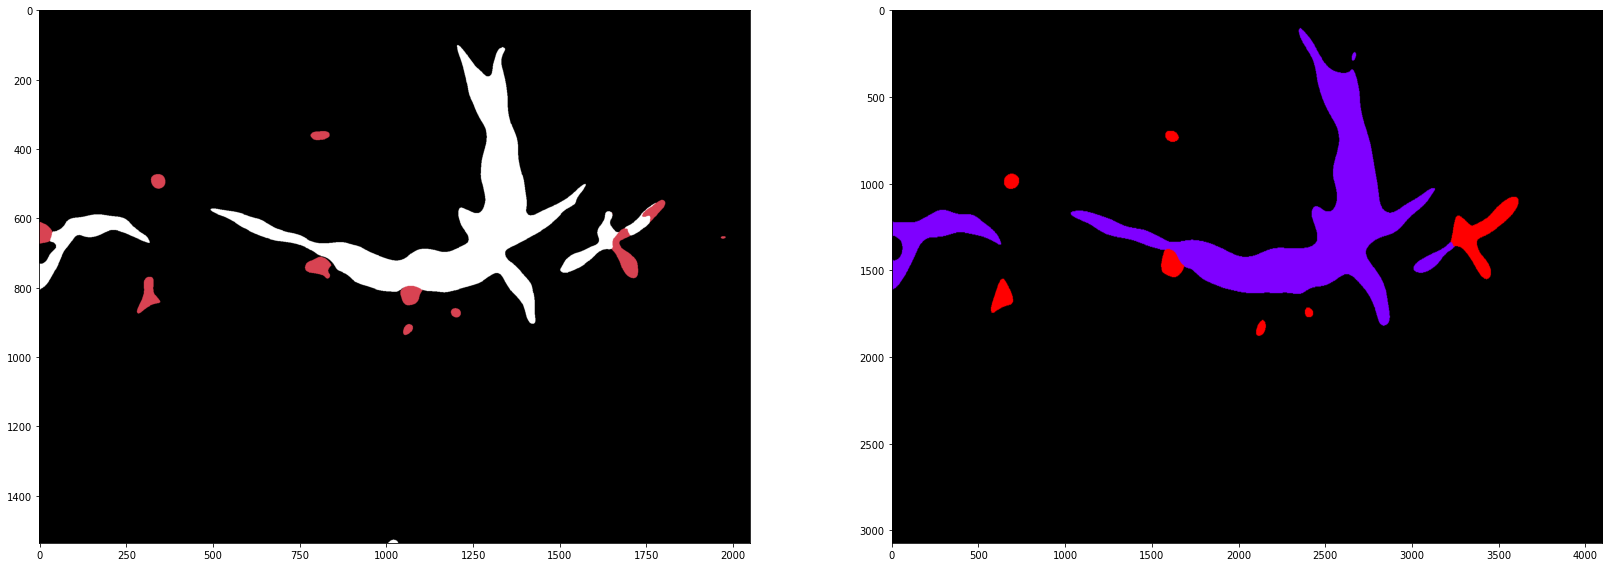

In [28]:
import os
import json
import numpy as np
from PIL import Image


def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)



# Just for completeness, here we show how the rle encoded mask
# is transformed back to a numpy array

# Read the submission.json file generated by the
# 'prepare_submission.py' script
with open('/content/drive/MyDrive/Final_weights/CNN_xce/results.json', 'r') as f:
    submission_dict = json.load(f)

img_name = 'Bipbip_mais_im_02211'
img_shape = submission_dict[img_name]['shape']

rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

# Reconstruct crop and weed binary masks
crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

# Reconstruct original mask
# weed_mask * 2 allows to convert ones into target 2 (weed label)
reconstructed_mask = crop_mask + (weed_mask * 2)

# Check that the RLE decoded mask is the same of the original mask
# before the RLE encoding
#original_mask = np.load('./predictions/arr_mask_example.npy')

#np.testing.assert_allclose(original_mask, reconstructed_mask)

# Just for visualisation purposes, save RGB reconstructed mask
# Use again the dictionary in 'RGBtoTarget.txt'.
reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
print(reconstructed_rgb_arr.shape)
reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

reconstructed_rgb_img = Image.fromarray(
    np.uint8(reconstructed_rgb_arr))

for key in x_test:
  if key == 'Bipbip_mais_im_02211.jpg':
    img_name = key.replace('.jpg', '').replace('.png', '')
    out_sigmoid = model.predict(x=tf.expand_dims(x_test[key], 0))

    # Get predicted class as the index corresponding to the maximum value in the vector probability
    # predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
    # predicted_class = predicted_class[0, ..., 0]
    predicted_class = tf.argmax(out_sigmoid, -1)

    predicted_class = predicted_class[0, ...]

    prediction_up = np.zeros([IMG_HEIGHT, IMG_WIDTH])
    prediction_up[np.where(predicted_class == 0)] = 0
    for i in range(1, 3):
      prediction_up[np.where(predicted_class == i)] = i
    mask_up = Image.fromarray(prediction_up)
    mask_up = mask_up.resize(size=(DEF_WIDTH*2, DEF_HEIGHT*2), resample=Image.NEAREST)
    prediction_up = np.array(mask_up)
    f = prediction_up == 1
    print(f.shape)

    prediction_img = np.zeros([prediction_up.shape[0], prediction_up.shape[1], 3])
    prediction_img[np.where(prediction_up == 0)] = [0, 0, 0]
    for i in range(1, 3):
      prediction_img[np.where(prediction_up == i)] = np.array(colors[i-1])[:3] * 255

fig, ax = plt.subplots(1, 2, figsize=(28, 28))
fig.show()
ax[0].imshow(reconstructed_rgb_img)
ax[1].imshow(np.uint8(prediction_img))


# Please notice that the 'unknown' class corresponding to the
# RGB value [216, 124, 18] is not considered for the evaluation
# and thus does not appear in the reconstructed mask.